In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import pyfrac
from pyfrac.utils.sofiutils import *

### ASSUMPTIONS
    measurements are in m/s
    vs is constantly 0.6 vp
    rho is computed by gardners 

In [2]:
def gardners_rho(vp,ms=True):
    if ms: alpha = 0.31
    else: alpha = 0.23
    beta = 0.25
    
    return alpha * vp**beta

In [3]:
def constantlayers_to_log(vp,interfacedepths,z):
    ''' 
    vp[0] corresponds to velocity of first layer 
    '''
    dz = z[1]
    
    z_old = np.hstack([z[0],interfacedepths,z[-1]])
    f_vp = sc.interpolate.interp1d(z_old, np.hstack([vp,vp[-1]]), kind='previous')
    return f_vp(z)

def plot_logs(vp,vs,rho,z, figsize=(5,5)):
    fig,axs = plt.subplots(1,3,figsize=figsize, sharey=True)
    axs[0].plot(vp,z, 'k')
    axs[1].plot(vs,z, 'k')
    axs[2].plot(rho,z, 'k')
    for ax in axs: ax.set_ylim([z[-1],z[0]])
    plt.tight_layout()
    axs[0].set_ylabel(r'$z$ $[m]$')
    axs[0].set_xlabel(r'$v_p$ $[m/s]$')
    axs[1].set_xlabel(r'$v_s$ $[m/s]$')
    axs[2].set_xlabel(r'$\rho$ $[g/cm^3]$')
    axs[0].set_title('P-Wave')
    axs[1].set_title('S-Wave')
    axs[2].set_title('Density')
    
    return axs

In [4]:
# 3 layer model - USER DEFINED
expname = 'simple3L'
outpath = '../../FDModelling/Simple3Layers/inputs'

dx, dy, dz = 5, 5, 5
xmin,xmax = [0, 640]
ymin,ymax = [0, 680] 
zmin,zmax = [0, 1000] 

vp_layers = [2500, 3000, 3500]
interfacedepths = [250, 500]


In [5]:
8*5

40

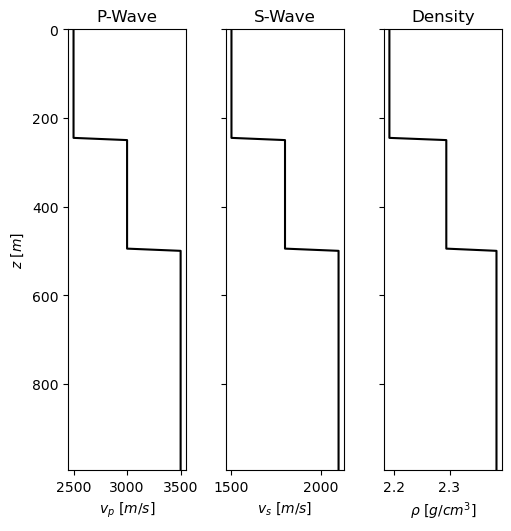

In [6]:
# Regular model
z = np.arange(zmin,zmax,dz)

vp  = constantlayers_to_log(vp_layers,interfacedepths,z)
vs  = 0.6 * vp
rho = gardners_rho(vp,ms=True)

_ = plot_logs(vp,vs,rho,z, figsize=(5,5))

(128, 136, 200)


(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='x samples', ylabel='t samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

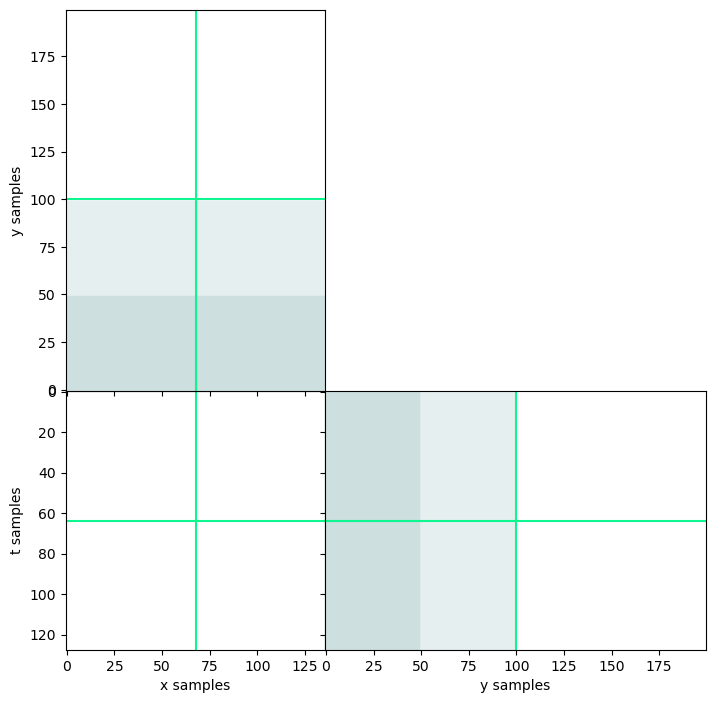

In [7]:
# make into 3D model
x = np.arange(xmin,xmax,dx)
nx = len(x)
y = np.arange(ymin,ymax,dy)
ny = len(y)

vel_mod = np.expand_dims(vp, axis=[0,1])
vp_mod = vel_mod.repeat(nx,axis=0).repeat(ny,axis=1)
vs_mod  = 0.6 * vp_mod
rho_mod = gardners_rho(vp_mod, ms=True)
print(vp_mod.shape)
pyfrac.visualisation.plotting_support.explode_volume(vp_mod)

In [8]:
# Write as binary
os.makedirs(os.path.join(outpath,'model/'), exist_ok=True)

vp_mod.astype(np.float32).tofile(os.path.join(outpath,'model/%s.vp'%expname))#,format='<f')
vs_mod.astype(np.float32).tofile(os.path.join(outpath,'model/%s.vs'%expname))  #,format='<f')
rho_mod.astype(np.float32).tofile(os.path.join(outpath,'model/%s.rho'%expname))  #,format='<f')

# vp_mod.transpose(0,2,1).astype(np.float32).tofile(os.path.join(outpath,'model/%s.vp'%expname))#,format='<f')
# vs_mod.transpose(0,2,1).astype(np.float32).tofile(os.path.join(outpath,'model/%s.vs'%expname))  #,format='<f')
# rho_mod.transpose(0,2,1).astype(np.float32).tofile(os.path.join(outpath,'model/%s.rho'%expname))  #,format='<f')

# Make Receiver File

In [9]:
def reg_surfacegeom_xzy(rec_x_params, rec_y_params, r_z, dp=2):
    # define params
    x_ri, x_rf, nr_x = rec_x_params[0], rec_x_params[1],  rec_x_params[2] 
    y_ri, y_rf, nr_y = rec_y_params[0], rec_y_params[1],  rec_y_params[2] 

    # RECEIVER GRID - ONLY ON CUBE SURFACES
    grid_x_locs = np.linspace(x_ri, x_rf, nr_x)
    grid_y_locs = np.linspace(y_ri, y_rf, nr_y)
    rx, ry, rz = np.meshgrid(grid_x_locs, grid_y_locs, r_z) 
    
    return np.vstack((np.round(rx.flatten(), decimals=dp),  
                      np.round(rz.flatten(), decimals=dp),
                      np.round(ry.flatten(), decimals=dp)))

In [10]:
nr_x = 10
nr_y = 8

rec_x_params = x[40],x[-40], nr_x
rec_y_params = y[45],y[-45], nr_y
r_z = z[1]

rec_xzy = reg_surfacegeom_xzy(rec_x_params, rec_y_params, r_z, dp=0)

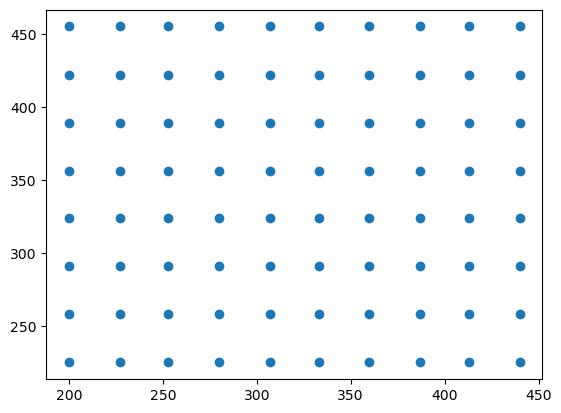

In [11]:
plt.scatter(rec_xzy[0],rec_xzy[2])

In [12]:
rec_xzy.shape

(3, 80)

In [13]:
# Save for SOFI
np.savetxt(os.path.join(outpath,'receiver.dat'),
           rec_xzy.T.astype(np.float32), 
           fmt='%.4f')

# Sources
XSRC		YSRC		ZSRC		TD		FC		AMP

In [14]:
sx, sy, sz = x[nx//2], y[2*ny//5], 700.
td = 1e-5
fc = 20.
amp = 1.
string_list = [str(i) for i in [sx, sz, sy, td, fc, amp]]
src_string = '\t'.join(string_list)
print(src_string)

text_file = open(os.path.join(outpath,'sources.dat'), "wt")
text_file.writelines(src_string)
text_file.close()

320	700.0	270	1e-05	20.0	1.0


# PARAMETER AND RUN FILES

In [15]:
# mod params
n_xzy = vp_mod.transpose(0,2,1).shape
d_xzy = [dx, dz, dy]

# time params (in seconds!)
dt = 1e-5
tdur = 0.5
tsnap_params = [dt, tdur-dt, dt*100]
smgrm_ndt = 100

SOFIjsonfilename = '../../FDModelling/Simple3Layers/SOFI3D_%s.json'%expname

sofimaster = '~/Documents/Projects/MicroseismicModelling/SOFI3D-master/bin/'
num_procs = 8
sofi_param_file = "SOFI3D_%s.json"%expname
shellfilename = "../../FDModelling/Simple3Layers/runSOFI3D_%s.sh"%expname



In [16]:
# GET THE DIFFERENT STRINGS - this will be updated in the future
default_strs = get_default_strings()

monitor_strs = get_monitor_str(tsnap_params, smgrm_ndt, expname)
t_str = get_time_str(dt, tdur)
mod_strs = get_subsurfmod_str(n_xzy, d_xzy,expname)
bndry_str = get_boundary_str(fs=True, npad=25, cpml=True, vppml=np.mean(vp_mod))
src_str = get_source_str()

write_SOFIjsonParams = write_SOFIjsonParams(default_strs, 
                                            monitor_strs,  
                                            t_str, 
                                            mod_strs, 
                                            src_str, 
                                            bndry_str, 
                                            SOFIjsonfilename)
runscript = write_SOFIrunScript(sofimaster, 
                                num_procs, 
                                sofi_param_file, 
                                shellfilename)